# 矩阵分解算法
- 协同过滤的缺点：推荐结果的头部效应明显，处理稀疏向量的能力弱．
- 矩阵分解图解
![](./imgs/LFM矩阵分解图解.png)

- 求解方法  
(1)特征值分解(适用于方阵).  
(2)奇异值分解(原始共现矩阵必须稠密).  
(3)梯度下降(<font color="red">重点</font>)  
- 计算公式(梯度下降法)  
![](./imgs/SVD.png)  
- 预测  
在对某用户进行推荐时，可利用该用户的隐向量与所有物品的隐向量进行逐一的内积运算，得出该用户对所有物品的评分预测，在依次进行排序，得到最终的推荐列表．

# 代码实践

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

dtype = [("userId", np.int32), ("movieId", np.int32), ("rating", np.float32)]
dataset = pd.read_csv("data/ratings.csv", usecols=range(3), dtype=dict(dtype))
DATA_PATH = "./data/ratings.csv"

In [51]:
def data_split(data_path, x = 0.8, random = False):
    """划分数据集合"""
    
    print("开始划分数据......")
    dtype = {"userId": np.int32, "movieId": np.int32, "rating": np.float32}
    # 加载数据，我们只用前三列数据，分别是用户ID，电影ID，已经用户对电影的对应评分
    ratings = pd.read_csv(data_path, dtype=dtype, usecols=range(3))
    
    testset_index = []
    
    for uid in ratings.groupby("userId").any().index:  # 获取index索引
        use_rating_data = ratings.where(ratings["userId"]==uid).dropna()
        if random:
            # shuffle
            index = list(use_rating_data.index)
            np.random.shuffle(index)
            _index = round(len(use_rating_data)*x)
            testset_index += list(index[_index:]) # 取出1-x的数据做测试
        else:
            index = round(len(use_rating_data)*x)
            testset_index += list(use_rating_data.index.values[index:])
            
    testset = ratings.loc[testset_index]
    trainset = ratings.drop(testset_index)
    print("完成数据集的切分......")
    
    return trainset, testset

In [52]:
class LFM(object):

    def __init__(self, alpha, reg_p, reg_q, number_LatentFactors=10, number_epochs=10, columns=["uid", "iid", "rating"]):
        
        self.alpha = alpha # 学习率
        self.reg_p = reg_p    # P矩阵正则
        self.reg_q = reg_q    # Q矩阵正则
        self.number_LatentFactors = number_LatentFactors  # 隐式类别数量
        self.number_epochs = number_epochs    # 最大迭代次数
        self.columns = columns
        self.total_loss = []
        
    def fit(self, dataset):
        
        self.dataset = pd.DataFrame(dataset)
        
        # 获取用户和物品的相应的评分表
        self.user_ratings = dataset.groupby(self.columns[0]).agg([list])[[self.columns[1], self.columns[2]]]
        self.item_ratings = dataset.groupby(self.columns[1]).agg([list])[[self.columns[0], self.columns[2]]]

        self.globalMean = self.dataset[self.columns[2]].mean()
        
        self.P, self.Q = self.sgd()
        
    def _init_matric(self):
        """初始化分解矩阵P、Q"""
        
        # 用户-->隐含特征｛user1:vector, user2:vector｝
        P = dict(zip(self.user_ratings.index, np.random.rand(len(self.user_ratings), self.number_LatentFactors).astype(np.float32)))
        
        # 物品-->隐含特征｛item1:vector, item2:vector｝
        Q = dict(zip(self.item_ratings.index, np.random.rand(len(self.item_ratings), self.number_LatentFactors).astype(np.float32)))
        
        return P, Q
    
    def sgd(self):
        """随机梯度下降"""
        
        P, Q = self._init_matric()
        
        for i in range(self.number_epochs):
            print("epoch:", i, end=" " )
            error_list = []
            for uid, iid, real in self.dataset.itertuples(index=False):
                v_pu = P[uid]  # 得到相应的用户向量
                v_qi = Q[iid]  # 得到相应的物品向量
                
                err = np.float32(real - np.dot(v_pu, v_qi))  # 误差项
                
                v_pu += self.alpha * (err * v_qi - self.reg_p * v_pu)  #　加入正则项L2
                v_qi += self.alpha * (err * v_pu - self.reg_q * v_qi)
                
                P[uid] = v_pu
                Q[iid] = v_qi
                
                error_list.append(err**2)
            self.total_loss.append(np.sqrt(np.mean(error_list)))
            print(" loss:", np.sqrt(np.mean(error_list)))
            
        return P, Q
    
    def predict(self, uid, iid):
        """预测"""
        
        if uid not in self.user_ratings.index or iid not in self.item_ratings.index:
            return self.globalMean
        
        p_u = self.P[uid]
        q_i = self.Q[iid]
        
        return round(np.dot(p_u, q_i), 2)
    
    def test(self,testset):
        '''预测测试集数据'''
    
        for uid, iid, real_rating in testset.itertuples(index=False):
            try:
                pred_rating = self.predict(uid, iid)
            except Exception as e:
                print(e)
            else:
                yield uid, iid, real_rating, pred_rating
                
    def plot_loss_curve(self):
        """绘制loss曲线"""
        
        plt.plot(self.total_loss)
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.show()

In [53]:
train_set, test_set = data_split(DATA_PATH)
lfm = LFM(0.01, 0.01, 0.01, columns=["userId", "movieId", "rating"])
lfm.fit(train_set)

开始划分数据......
完成数据集的切分......
epoch: 0  loss: 1.0431547138329398
epoch: 1  loss: 0.9039604854573872
epoch: 2  loss: 0.8642523677705397
epoch: 3  loss: 0.843922869599573
epoch: 4  loss: 0.8297960571372004
epoch: 5  loss: 0.8185910297484107
epoch: 6  loss: 0.8089114535937874
epoch: 7  loss: 0.800039663441265
epoch: 8  loss: 0.7915701068816567
epoch: 9  loss: 0.7832709857508555


In [54]:
test_all = lfm.test(testset=test_set)
# list(test_all)

In [55]:
lfm.predict(1, 1)

4.48

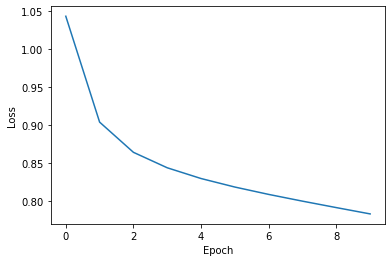

In [56]:
lfm.plot_loss_curve()

# 矩阵分解优缺点
## 优点
- 泛化能力更强
- 空间复杂度低
- 更好的扩展性和灵活性

## 缺点
- 丧失了利用很多有效信息的机会，同时缺乏用户历史行为，无法进行有效的推荐。

# 知识点

In [57]:
columns=["userId", "movieId", "rating"]
user_ratings = dataset.groupby(columns[0]).agg([list])[[columns[1], columns[2]]]
item_ratings = dataset.groupby(columns[1]).agg([list])[[columns[0], columns[2]]]

In [58]:
user_ratings.head()

,movieId,rating
,list,list
userId,,
1,"[1, 3, 6, 47, 50, 70, 101, 110, 151, 157, 163,...","[4.0, 4.0, 4.0, 5.0, 5.0, 3.0, 5.0, 4.0, 5.0, ..."
2,"[318, 333, 1704, 3578, 6874, 8798, 46970, 4851...","[3.0, 4.0, 4.5, 4.0, 4.0, 3.5, 4.0, 4.0, 4.5, ..."
3,"[31, 527, 647, 688, 720, 849, 914, 1093, 1124,...","[0.5, 0.5, 0.5, 0.5, 0.5, 5.0, 0.5, 0.5, 0.5, ..."
4,"[21, 32, 45, 47, 52, 58, 106, 125, 126, 162, 1...","[3.0, 2.0, 3.0, 2.0, 3.0, 3.0, 4.0, 5.0, 1.0, ..."
5,"[1, 21, 34, 36, 39, 50, 58, 110, 150, 153, 232...","[4.0, 4.0, 4.0, 4.0, 3.0, 4.0, 5.0, 4.0, 3.0, ..."


In [59]:
P = dict(zip(user_ratings.index, np.random.rand(len(user_ratings), 10).astype(np.float32)))

In [60]:
np.random.rand(2, 4)

array([[0.66498344, 0.31443646, 0.83987127, 0.21600031],
       [0.81701453, 0.3117096 , 0.56137987, 0.01247667]])

In [61]:
len(user_ratings)

610

{1: array([0.24171513, 0.3247105 , 0.14458191, 0.9336254 , 0.4926182 ,
        0.67485064, 0.970499  , 0.6683635 , 0.17384623, 0.30623397],
       dtype=float32),
 2: array([0.49624184, 0.73284215, 0.09986558, 0.12987737, 0.30734062,
        0.9393964 , 0.46322092, 0.37099287, 0.04578225, 0.51759773],
       dtype=float32),
 3: array([0.8675892 , 0.73728263, 0.6990476 , 0.77752274, 0.7249771 ,
        0.40668082, 0.37144965, 0.10250618, 0.10227007, 0.51732653],
       dtype=float32),
 4: array([0.7424323 , 0.17426105, 0.7665084 , 0.40588063, 0.9138953 ,
        0.34136656, 0.30895534, 0.00564423, 0.7546588 , 0.04759226],
       dtype=float32),
 5: array([0.68609625, 0.40079167, 0.1833938 , 0.67653155, 0.37907687,
        0.87130904, 0.17819478, 0.3688559 , 0.42266932, 0.24728157],
       dtype=float32),
 6: array([0.32303467, 0.70297146, 0.8979267 , 0.8117592 , 0.34070757,
        0.1848536 , 0.23341532, 0.01050721, 0.9571083 , 0.6909441 ],
       dtype=float32),
 7: array([0.6814172 ,